In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
from tqdm import tqdm

In [3]:
train_path = 'L:/DeepLearning/train'
test_path = 'L:/DeepLearning/test'

In [4]:
def load_data(path):
    images = []
    labels = []
    for image_name in os.listdir(path):
        images_path = os.path.join(path, image_name)
        images.append(images_path)

        finger_num = int(image_name[-5])
        labels.append(finger_num)
        
    return images, np.array(labels, dtype='uint8')

In [5]:
train_images, train_labels = load_data(train_path)
test_images, test_labels = load_data(test_path)

In [6]:
def visualize_images(image_paths, image_labels, rows=2, cols=5, random=True):
    num_display = rows * cols

    num_display = min(num_display, len(image_paths))

    if random:
        indices = np.random.randint(0, len(image_paths), num_display)
    else:
        indices = np.arange(num_display)

    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))

    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    
    for i, idx in enumerate(indices):
        row = i // cols
        col = i % cols

        try:
            img = Image.open(image_paths[idx])
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'Finger: {image_labels[idx]}')
            axes[row, col].axis('off')
        except FileNotFoundError:
            print(f'File not found: {image_paths[idx]}')
        except Exception as e:
            print(f'Image processing error {image_paths[idx]}: {e}')
    
    for i in range(num_display, rows * cols):
        row = i // cols
        col = i % cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

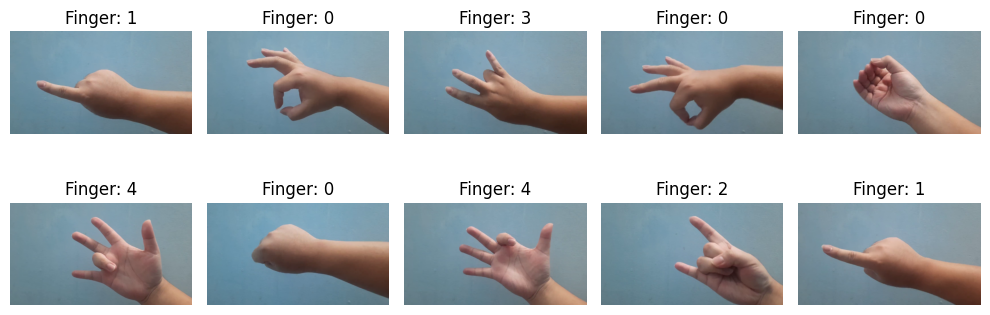

In [7]:
visualize_images(train_images, train_labels)

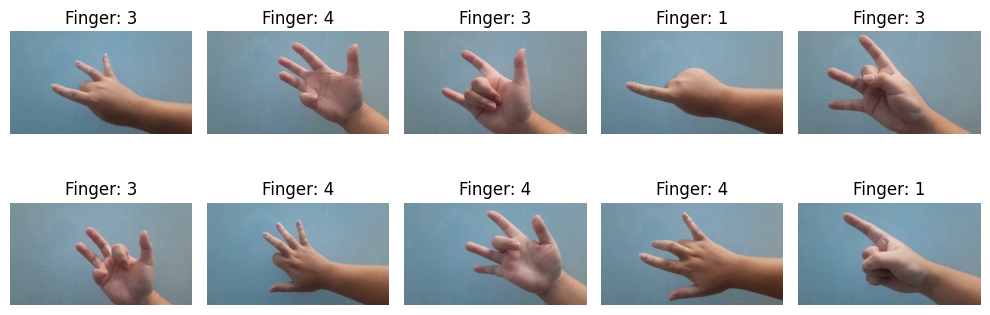

In [8]:
visualize_images(test_images, test_labels)

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    transforms.RandomApply([transforms.RandomRotation(degrees=45)], p=0.5),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=(3, 3)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=0)
])

In [10]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, is_train=True):
        self.images = images
        self.labels = labels
        self.is_train = is_train

        if self.is_train:
            self.transform = train_transform
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)

        return image, label
    
    def __len__(self):
        return len(self.images)

In [12]:
train = CustomDataset(train_images, train_labels, is_train=True)
vaid = CustomDataset(val_images, val_labels, is_train=False)
test = CustomDataset(test_images, test_labels, is_train=False)

In [13]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(vaid, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [14]:
for (data, target) in train_loader:
    print('data :', data.size(), 'type :', data.type())
    print('target :', target.size(), 'type :', target.type())
    break

data : torch.Size([32, 3, 224, 224]) type : torch.FloatTensor
target : torch.Size([32]) type : torch.LongTensor


In [15]:
for (data, target) in val_loader:
    print('data :', data.size(), 'type :', data.type())
    print('target :', target.size(), 'type :', target.type())
    break

data : torch.Size([32, 3, 224, 224]) type : torch.FloatTensor
target : torch.Size([32]) type : torch.LongTensor


In [16]:
for (data, target) in test_loader:
    print('data :', data.size(), 'type :', data.type())
    print('target :', target.size(), 'type :', target.type())
    break

data : torch.Size([32, 3, 224, 224]) type : torch.FloatTensor
target : torch.Size([32]) type : torch.LongTensor


In [17]:
model = models.vgg16(weights='DEFAULT')
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')

CPU


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc='Training', unit='batch'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(100 * correct / total)

    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader,desc='Validating'):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    val_loss.append(val_running_loss / len(val_loader))
    val_acc.append(100 * val_correct / val_total)

    print(f'\tTrain Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%\n\tVal Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%')

Epoch 1/5


Validating: 100%|██████████| 13/13 [01:31<00:00,  7.05s/it]


	Train Loss: 1.7969, Train Acc: 37.25%
	Val Loss: 0.7985, Val Acc: 66.50%
Epoch 2/5


Validating: 100%|██████████| 13/13 [01:32<00:00,  7.13s/it]


	Train Loss: 0.6259, Train Acc: 72.62%
	Val Loss: 0.4667, Val Acc: 76.00%
Epoch 3/5


Validating: 100%|██████████| 13/13 [01:36<00:00,  7.43s/it]


	Train Loss: 0.3851, Train Acc: 85.31%
	Val Loss: 0.1006, Val Acc: 97.00%
Epoch 4/5


Validating: 100%|██████████| 13/13 [01:46<00:00,  8.21s/it]


	Train Loss: 0.2040, Train Acc: 92.12%
	Val Loss: 0.0675, Val Acc: 98.00%
Epoch 5/5


Validating: 100%|██████████| 13/13 [01:25<00:00,  6.58s/it]

	Train Loss: 0.1182, Train Acc: 96.50%
	Val Loss: 0.0454, Val Acc: 98.50%


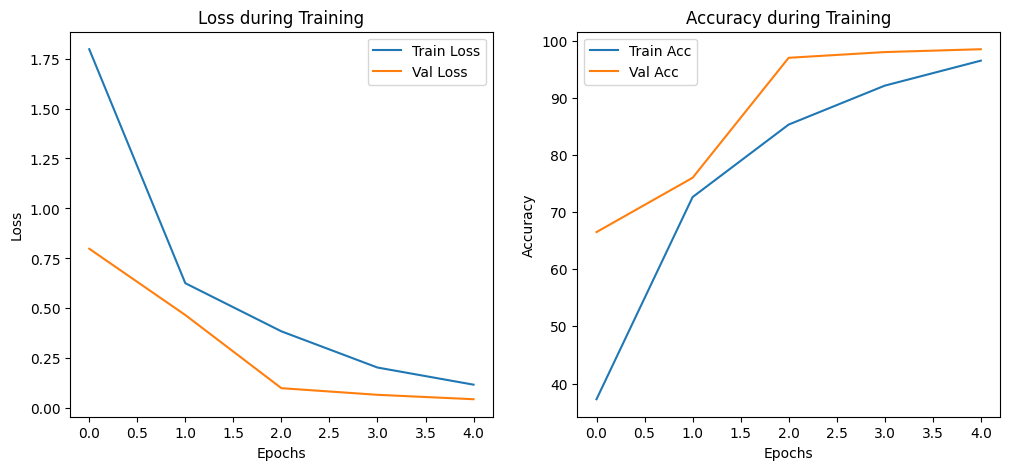

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [22]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing', unit='batch'):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"Recall: {recall_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted')*100:.2f}%")

Testing: 100%|██████████| 7/7 [00:43<00:00,  6.15s/batch]

Accuracy: 99.50%
F1 Score: 99.50%
Recall: 99.50%
Precision: 99.51%


In [ ]:
""""
Note: Bổ sung thêm 
Save, Load epoch đang train
Kiểm tra tối ưu valid -> ngưng vòng lặp
confusion_matrix
phương pháp transfer learning
"""